# Link analysis

Inspired by and borrowed heavily from: Collective Intelligence - [Luís F. Simões](mailto:luis.simoes@vu.nl)  
IR version and assignments by J.E. Hoeksema, 2014-11-12

*******

This notebook's purpose is to give examples of how to use graph algorithms to improve search engine. We look at two graphs in particular: the co-authorship, and citations networks.

## Loading modules & datasets

In [1]:
import cPickle, bz2
from collections import *

import numpy as np
import matplotlib.pyplot as plt

# show plots inline within the notebook
%matplotlib inline
# set plots' resolution
plt.rcParams['savefig.dpi'] = 100

from IPython.display import display, HTML

In [2]:
search_term = 'evolution'

Ids_file       = search_term + '__Ids.pkl.bz2'
Summaries_file = search_term + '__Summaries.pkl.bz2'
Citations_file = search_term + '__Citations.pkl.bz2'

In [3]:
Ids = cPickle.load( bz2.BZ2File( Ids_file, 'rb' ) )

In [4]:
Summaries = cPickle.load( bz2.BZ2File( Summaries_file, 'rb' ) )

paper = namedtuple( 'paper', ['title', 'authors', 'year', 'doi'] )

for (id, paper_info) in Summaries.iteritems():
    Summaries[id] = paper( *paper_info )

In [5]:
Citations = cPickle.load( bz2.BZ2File( Citations_file, 'rb' ) )

## Auxiliary functions

The function below will allow us to display paper summaries in an IPython-aware way.

You can find examples [here](http://nbviewer.ipython.org/urls/raw.github.com/ipython/ipython/1.x/examples/notebooks/Part%205%20-%20Rich%20Display%20System.ipynb) of how to use IPython's Rich Display System, or the whole set of examples [here](https://github.com/ipython/ipython/tree/1.x/examples/notebooks).

In [6]:
def display_summary( id, extra_text='' ):
    """
    Function for printing a paper's summary through IPython's Rich Display System.
    Trims long titles or author lists, and links to the paper's  DOI (when available).
    """
    s = Summaries[ id ]
    
    title = ( s.title if s.title[-1]!='.' else s.title[:-1] )
    title = title[:150].rstrip() + ('' if len(title)<=150 else '...')
    if s.doi!='':
        title = '<a href=http://dx.doi.org/%s>%s</a>' % (s.doi, title)
    
    authors = ', '.join( s.authors[:5] ) + ('' if len(s.authors)<=5 else ', ...')
    
    lines = [
        title,
        authors,
        str(s.year),
        '<small>id: %d%s</small>' % (id, extra_text)
        ]
    
    display( HTML( '<blockquote>%s</blockquote>' % '<br>'.join(lines) ) )

In [7]:
# usage example
display_summary( 23144668 )

## Co-authorship network

`Summaries` maps paper *ids* to paper *summaries*. Let us now create here mappings by different criteria.

We'll start by building a mapping from *authors*, to the set of *ids* of papers they authored. 
We'll be using Python's [sets](http://docs.python.org/2/library/stdtypes.html#set-types-set-frozenset) for that purpose.

In [8]:
papers_of_author = defaultdict(set)

for id,p in Summaries.iteritems():
    for a in p.authors:
        papers_of_author[ a ].add( id )

In [9]:
papers_of_author['Eiben AE']

{10021763, 23144668}

In [10]:
for id in papers_of_author['Eiben AE']:
    display_summary( id )

We now build a co-authorship network, a graph linking *authors*, to the set of *co-authors* they have published with.

In [11]:
coauthors = defaultdict(set)

for p in Summaries.itervalues():
    for a in p.authors:
        coauthors[ a ].update( p.authors )

# the code above results in each author being listed as having co-autored with himself. We now remove such references here
for a,ca in coauthors.iteritems():
    ca.remove( a )

In [12]:
print ', '.join( coauthors['Eiben AE'] )

Haasdijk E, Bäck T, Kernbach S


Because both an author's papers, and its collaborators are stored as Python sets, we can then use [set operations](http://docs.python.org/2/library/stdtypes.html#set-types-set-frozenset) to easily combine different sets, with low computational complexity. Here are a few examples.

The intersection of two author's publication records, can be used to obtain the set of papers they co-authored together:

In [13]:
for id in papers_of_author['Wilson EO'] & papers_of_author['Nowak MA']:
    display_summary( id )

The intersection of two author's collaborators sets, identifies people they have both published with:

In [14]:
coauthors[u'Bäck T'] & coauthors['Haasdijk E']

{'Eiben AE'}

Set difference, allows us to exclude papers that were published with some given author from an author's publication record:

In [15]:
for id in papers_of_author['Eiben AE'] - papers_of_author['Haasdijk E']:
    display_summary( id )

Imagine you know who the members of a research group are, and want to obtain the union of all papers published by the group's members. Most certainly, there is plenty of collaboration among group members, with many papers authored together, but we want to obtain a list of publications with no duplicate entries. Here is a way to achieve that, using Python's [reduce](http://docs.python.org/2/library/functions.html#reduce) function, to iteratively perform a union of all their publication records. We take as example three current or former members from the [IRIDIA](http://code.ulb.ac.be/iridia.home.php) lab. The make the list shorter, we show only 5 of the resulting papers.

In [16]:
authors = [ 'Dorigo M', 'Trianni V', 'Lenaerts T' ]

group_publications = reduce( set.union, [ papers_of_author[a] for a in authors ], set() )

for id in list(group_publications)[5:10]:
    display_summary( id )

### Network statistics

In [17]:
print 'Number of nodes: %8d (node == author)' % len(coauthors)
print 'Number of links: %8d (link == collaboration between the two linked authors on at least one paper)'  \
        % sum( len(cas) for cas in coauthors.itervalues() )

Number of nodes:   424178 (node == author)
Number of links:  6865432 (link == collaboration between the two linked authors on at least one paper)


#### [Degree distribution](https://en.wikipedia.org/wiki/Degree_distribution)

With this data in hand, we can plot the distribution showing the number of collaborators a scientist has published with in its full publication record:

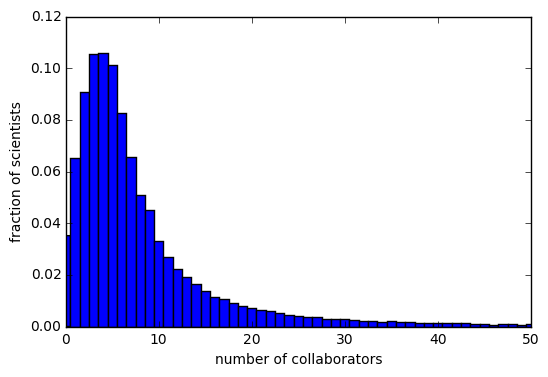

In [18]:
plt.hist( x=[ len(ca) for ca in coauthors.itervalues() ], bins=range(55), histtype='bar', align='left', normed=True )
plt.xlabel('number of collaborators')
plt.ylabel('fraction of scientists')
plt.xlim(0,50);

## Citations network

We'll start by expanding the `Citations` dataset into two mappings: 

* `papers_citing[ id ]`: papers citing a given paper;
* `cited_by[ id ]`: papers cited by a given paper (in other words, its list of references).

If we see the Citations dataset as a directed graph where papers are nodes, and citations links between then, then `papers_citing` gives you the list of a node's incoming links, whereas `cited_by` gives you the list of its outgoing links.

The dataset was assembled by querying for papers citing a given paper. As a result, the data mapped to in `cited_by` (its values) is necessarily limited to ids of papers that are part of the dataset (they are members of `Ids`). Two papers that are never cited, but do themselves cite many of the same papers (papers that are not members of `Ids`), are probably similar/relevant to each other. Unfortunately, that kind of data is not currently available.

In [19]:
papers_citing = Citations  # no changes needed, this is what we are storing already in the Citations dataset

cited_by = defaultdict(list)

for ref, papers_citing_ref in papers_citing.iteritems():
    for id in papers_citing_ref:
        cited_by[ id ].append( ref )

Let us now look at an arbitrary paper, let's say PubMed ID 20949101 ("Critical dynamics in the evolution of stochastic strategies for the iterated prisoner's dilemma"). We can now use the `cited_by` mapping to retrieve what we know of its list of references.

As mentioned above, because the process generating the dataset asked for papers citing a given paper (and not papers a paper cites), the papers we get through `cited_by` are then necessarily all members of our datasets, and we can therefore find them in `Summaries`.

You can match the list below with [the paper's References section](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC2951343/#__ref-listid953859title). We have identified 22 of its references, from a total of 52.

In [20]:
paper_id = 20949101
refs = { id : Summaries[id].title for id in cited_by[20949101] }
print len(refs), 'references identified for the paper with id', paper_id
refs

22 references identified for the paper with id 20949101


{5875340: 'The genetical evolution of social behaviour. II.',
 7466396: 'The evolution of cooperation.',
 8316296: "A strategy of win-stay, lose-shift that outperforms tit-for-tat in the Prisoner's Dilemma game.",
 10201376: "Prisoner's dilemma in an RNA virus.",
 10525399: 'Evolution of cooperation in spatially structured populations',
 10781045: 'Evolution of biological complexity.',
 11140681: 'Altruism and social cheating in the social amoeba Dictyostelium discoideum.',
 11544353: 'Quorum sensing in bacteria.',
 11719803: 'Evolution of cooperation without reciprocity.',
 12736677: 'The evolutionary origin of complex features.',
 15071593: 'Emergence of cooperation and evolutionary stability in finite populations.',
 16251955: 'Evolution of indirect reciprocity.',
 16724065: 'A simple rule for the evolution of cooperation on graphs and social networks.',
 16829575: 'Evolution of cooperation by multilevel selection.',
 17087973: 'The evolution of altruism: game theory in multilevel s

If we lookup the same paper in `papers_citing`, we now see that one of the papers citing it is itself part of our dataset, but the other one (with PubMed ID 23903782) is instead a citation coming from outside the dataset. If we would look this up in PubMed, we would see that this id corresponds to the paper 'Evolutionary instability of zero-determinant strategies demonstrates that winning is not everything'. However, being an "outsider", its information is not in `Summaries`. Of course, you can always issue a new Entrez query to get its details if you want to, but that is outside the scope of this assignment.

In [21]:
{ id : Summaries.get(id,['??'])[0]  for id in papers_citing[paper_id] }

{23903782: '??',
 24003115: "From extortion to generosity, evolution in the Iterated Prisoner's Dilemma."}

Of course, though no direct query was ever issued for this paper id 23903782, its repeated occurrence in other papers' citation lists does allow us to reconstruct a good portion of its references. Below is the list of papers in our dataset cited by that paper (10 references, out of the paper's total of 32, as you can see [here](http://www.nature.com/ncomms/2013/130801/ncomms3193/full/ncomms3193.html#references)):

In [22]:
paper_id2 = 23903782
refs2 = { id : Summaries[id].title for id in cited_by[paper_id2] }
print len(refs2), 'references identified for the paper with id', paper_id2
refs2

10 references identified for the paper with id 23903782


{5875340: 'The genetical evolution of social behaviour. II.',
 7466396: 'The evolution of cooperation.',
 8316296: "A strategy of win-stay, lose-shift that outperforms tit-for-tat in the Prisoner's Dilemma game.",
 10976075: 'Fairness versus reason in the ultimatum game.',
 11719803: 'Evolution of cooperation without reciprocity.',
 12736677: 'The evolutionary origin of complex features.',
 17342204: 'Chromodynamics of cooperation in finite populations.',
 20949101: "Critical dynamics in the evolution of stochastic strategies for the iterated prisoner's dilemma.",
 21697174: 'Impact of epistasis and pleiotropy on evolutionary adaptation.',
 22400598: 'Evolution and stability of altruist strategies in microbial games.'}

We can easily combine boh mappings (incoming and outgoing links) to answer such questions as: "which papers are the most cited by those that cite a given paper?".

Going back to our example paper ("Critical dynamics in the evolution of stochastic strategies for the iterated prisoner's dilemma"), we find two references that are commonly cited by the two papers citing it. If you look above to the list of papers our paper cites, you find that actually, the paper itself also cites these same two references, indicating that they are somehow particularly relevant to this line of research.

In [23]:
# Counter built over list of papers cited by papers that cite a given id
cocited = Counter([
    ref
    for citers in papers_citing[ paper_id ]
    for ref in cited_by[ citers ]
    if ref != paper_id
    ])

# discard papers cited only once
cocited = { id : nr_cocits for (id, nr_cocits) in cocited.iteritems() if nr_cocits > 1 }


for (id, times_co_cited) in sorted( cocited.items(), key=lambda i:i[1], reverse=True ):
    display_summary( id, ', nr. co-citations: %d' % times_co_cited )

A final implementation note regarding `cited_by`: the way it was built, only papers cited at least once appear as keys in it. With `cited_by` being a [defaultdict](http://docs.python.org/2/library/collections.html#collections.defaultdict), attempts to access a missing element will silently cause it to be added (with an empty list as vale, in this case), instead of raising an exception. Just take note that if you iterate over keys in `cited_by`, you are not iterating over all of the graph's nodes.

As an example, here's an isolated node in the graph, an old paper for which we have no citation data (neither to nor from).

In [24]:
display_summary( Ids[-1] )

In [25]:
papers_citing[ 21373130 ]

[]

In [26]:
21373130 in cited_by

False

In [27]:
cited_by[ 21373130 ]

[]

In [28]:
21373130 in cited_by

True

In [29]:
# just to revert to the way things were
del cited_by[ 21373130 ]

Should you want to "lock" `cited_by`, to make it behave as a regular Python dictionary, just convert it like this:

In [30]:
cited_by = dict(cited_by)

### Network statistics

Now that we have a better understanding about the data we're dealing with, let us obtain some basic statistics about our graph.

In [31]:
print 'Number of core ids %d (100.00 %%)' % len(Ids)

with_cit = [ id for id in Ids if papers_citing[id]!=[] ]
print 'Number of papers cited at least once: %d (%.2f %%)' % (len(with_cit), 100.*len(with_cit)/len(Ids))

isolated = set( id for id in Ids if papers_citing[id]==[] and id not in cited_by )
print 'Number of isolated nodes: %d (%.2f %%)\n\t'   \
      '(papers that are not cited by any others, nor do themselves cite any in the dataset)'% (
    len(isolated), 100.*len(isolated)/len(Ids) )

noCit_withRefs = [ id for id in Ids if papers_citing[id]==[] and id in cited_by ]
print 'Number of dataset ids with no citations, but known references: %d (%.2f %%)' % (
    len(noCit_withRefs), 100.*len(noCit_withRefs)/len(Ids))

print '(percentages calculated with respect to just the core ids (members of `Ids`) -- exclude outsider ids)\n'

Number of core ids 205344 (100.00 %)
Number of papers cited at least once: 112185 (54.63 %)
Number of isolated nodes: 87837 (42.78 %)
	(papers that are not cited by any others, nor do themselves cite any in the dataset)
Number of dataset ids with no citations, but known references: 5322 (2.59 %)
(percentages calculated with respect to just the core ids (members of `Ids`) -- exclude outsider ids)



In [32]:
Ids_set    = set( Ids )
citing_Ids = set( cited_by.keys() ) # == set( c for citing in papers_citing.itervalues() for c in citing )

outsiders = citing_Ids - Ids_set    # set difference: removes from `citing_Ids` all the ids that occur in `Ids_set`
nodes     = citing_Ids | Ids_set - isolated     # set union, followed by set difference

print 'Number of (non-isolated) nodes in the graph: %d\n\t(papers with at least 1 known citation, or 1 known reference)' % len(nodes)
print len( citing_Ids ), 'distinct ids are citing papers in our dataset.'
print 'Of those, %d (%.2f %%) are ids from outside the dataset.\n' % ( len(outsiders), 100.*len(outsiders)/len(citing_Ids) )

Number of (non-isolated) nodes in the graph: 547438
	(papers with at least 1 known citation, or 1 known reference)
460172 distinct ids are citing papers in our dataset.
Of those, 429931 (93.43 %) are ids from outside the dataset.



In [33]:
all_cits      = [ c for citing in papers_citing.itervalues() for c in citing ]
outsider_cits = [ c for citing in papers_citing.itervalues() for c in citing if c in outsiders ]

print 'Number of links (citations) in the graph:', len(all_cits)
print 'A total of %d citations are logged in the dataset.' % len(all_cits)
print 'Citations by ids from outside the dataset comprise %d (%.2f %%) of that total.\n' % (
    len(outsider_cits),
    100.*len(outsider_cits)/len(all_cits) )

Number of links (citations) in the graph: 1157723
A total of 1157723 citations are logged in the dataset.
Citations by ids from outside the dataset comprise 890613 (76.93 %) of that total.



#### Most cited papers

Let us now find which 10 papers are the most cited in our dataset.

In [34]:
nr_cits_per_paper = [ (id, len(cits)) for (id,cits) in papers_citing.iteritems() ]

for (id, cits) in sorted( nr_cits_per_paper, key=lambda i:i[1], reverse=True )[:10]:
    display_summary( id, ', nr. citations: <u>%d</u>' % cits )

The most cited paper in our dataset "Initial sequencing and analysis of the human genome", has 3258 citations, which is ~20% of the citations Google Scholar recognizes for it (see [here](http://scholar.google.com/scholar?q=10.1038%2F35057062)).

## Link Analysis for Search Engines

In order to use the citation network, we need to be able to perform some complex graph algorithms on it. To make our lives easier, we will load the data into the python package NetworkX, a package for the creation, manipulation, and study of the structure, dynamics, and function of complex networks, which provides a number of these graph algorithms (such as HITS and PageRank) out of the box.

In [35]:
import networkx as nx

G = nx.DiGraph(cited_by)

We now have a NetworkX Directed Graph stored in `G`, where a node represents a paper, and an edge represents a citation. This means we can now apply the [algorithms](http://networkx.github.io/documentation/networkx-1.9.1/reference/algorithms.html) and [functions](http://networkx.github.io/documentation/networkx-1.9.1/reference/functions.html) of NetworkX to our graph:

In [36]:
print nx.info(G)
print nx.is_directed(G)
print nx.density(G)

Name: 
Type: DiGraph
Number of nodes: 547438
Number of edges: 1157723
Average in degree:   2.1148
Average out degree:   2.1148
True
3.86309665132e-06


As this graph was generated from citations only, we need to add all isolated nodes (nodes that are not cited and do not cite other papers) as well:

In [37]:
G.add_nodes_from(isolated)

In [38]:
print nx.info(G)
print nx.is_directed(G)
print nx.density(G)

Name: 
Type: DiGraph
Number of nodes: 635275
Number of edges: 1157723
Average in degree:   1.8224
Average out degree:   1.8224
True
2.86867808205e-06


## Assignments

* Plot the degree distribution for the citation network. What can you tell about the shape of this distribution, and what does this tell us about the network?

* Using the [Link Analysis](networkx.github.io/documentation/networkx-1.9.1/reference/algorithms.link_analysis.html) algorithms provided by NetworkX, calculate the PageRank score for each node in the citation network, and store it somewhere. Also calculate the HITS hubs and authority scores for each node, and store them in another variable.
  <small>Hint: the `pagerank_scipy` and `hits_scipy` implementations tend to be considerably faster than their regular `pagerank` and `hits` counterparts</small>

* Copy your search engine from mini-assignment 3, and create a version that incorporates a paper's PageRank score in it's final score in, addition to tfidf

* Create another version of your search engine, this time using the paper's HITS values together with tfidf in the scoring function this time

* Explain how you combined the tfidf score, and graph-based scores in the assignments above? Did you value one over the other, or treated them equally? Why?